In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import math
import os
import random
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Download Data From Yahoo Finance
----
* XLE: Energy from 1998/12/16

* XLU: Utilities from 1998/12/16

* XLK: Technology from 1998/12/16

* XLB: Materials from 1998/12/16

* XLP: Consumer Staples from 1998/12/16

* XLY: Consumer Discretionary from 1998/12/16

* XLI: Industrial from 1998/12/16

* XLV: Health Care from 1998/12/16

* XLF: Financials from 1998/12/16

* XLRE: Real Estates from 2015/10/17

* XLC: Communication Services from 2018/06/18

In [3]:
def get_historical_Data(ticker, start, end):
    start_date = datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')
    data = pd.DataFrame()
    for j in range(6):
        data = pd.concat([data, pd.DataFrame(yf.download(ticker, start=start_date, 
                                                         end=end_date).iloc[:, j])], axis=1)
        
    data['name'] = ticker
    data = data[['name', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    return data

def download_data(ticker_list, start, end):
    data = pd.DataFrame()
    
    for ticker in ticker_list:
        new = get_historical_Data(ticker, start, end)
        data = pd.concat([data, new], axis = 0)
        
    return data

In [4]:
ticker_list = ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF']

data = download_data(ticker_list, '1998-12-16', '2022-12-31')

data['log_hl'] = np.log((data['High'] / data['Low'])+1e-5)
data['log_co'] = np.log((data['Close'] / data['Open'])+1e-5)
data['Adj_Close_pct_change'] = data.groupby('name')['Adj Close'].pct_change()
data['log_volume'] = np.log(data['Volume']+1e-5)
data = data[['name','Adj_Close_pct_change', 'log_volume', 'log_co', 'log_hl']]
data.dropna(inplace = True)
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,name,Adj_Close_pct_change,log_volume,log_co,log_hl
Date,,,,,
1998-12-23,XLE,0.020819,11.124317,0.017263,0.018603
1998-12-24,XLE,-0.005264,9.417355,-0.007895,0.009239
1998-12-28,XLE,-0.005291,9.510445,-0.010572,0.017263
1998-12-29,XLE,0.009974,9.998798,0.007278,0.016605
1998-12-30,XLE,-0.015142,9.989665,-0.014589,0.015277
...,...,...,...,...,...
2022-12-23,XLF,0.005628,16.655536,0.006215,0.012738
2022-12-27,XLF,-0.000295,17.058146,-0.002344,0.008846
2022-12-28,XLF,-0.003536,17.009893,-0.005298,0.009145


# DataFrame to Torch

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device = {device}")

Device = cpu


In [389]:
X_list = []
y_list = []
#window size: w
w = 10

for ticker in ticker_list:
    df = data[data['name'] == ticker][['Adj_Close_pct_change', 'log_volume', 'log_co', 'log_hl']]
    features = torch.tensor(df.values.astype(np.float32))
    label = torch.tensor(df['Adj_Close_pct_change'].values.astype(np.float32))
    X = features.unfold(0, w, 1)[:-1].to(torch.float32).to(device)
    Y = label[w:].to(torch.float32).to(device)
    X_list.append(X)
    y_list.append(Y)
    
X = torch.stack(X_list).transpose(0, 1)
y = torch.stack(y_list).transpose(0, 1)

X.shape, y.shape

(torch.Size([6035, 9, 4, 10]), torch.Size([6035, 9]))

# Split Data

Train: 70%  

Valid: 15%  

Test: 15%

In [390]:
from sklearn.model_selection import train_test_split

X_train, X_rem, y_train, y_rem = train_test_split(X, y, 
                                                  test_size=0.3,
                                                  shuffle = False)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, 
                                                    test_size=0.5,
                                                    shuffle = False)

len(X_train), len(X_valid),len(X_test), len(y_train), len(y_valid), len(y_test)

(4224, 905, 906, 4224, 905, 906)

# Data Loader

In [391]:
from torch.utils.data import TensorDataset, DataLoader

#Put Features and Labels Together
train_data = TensorDataset(X_train, y_train)
valid_data = TensorDataset(X_valid, y_valid)
test_data = TensorDataset(X_test, y_test)

# Setup the batch size hyperparameter
BATCH_SIZE = 64
# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=False# shuffle data every epoch?
)

valid_dataloader = DataLoader(valid_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [392]:
first_batch = next(iter(train_dataloader))[0]
first_batch.shape

torch.Size([64, 9, 4, 10])

# Model

In [399]:
import torch.nn as nn

class GetLSTMOutput(nn.Module): #To Ignore the second output of LSTM Layer
    def forward(self, x):
        out, _ = x
        return out
    
class newmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm2d(9),
            nn.Conv2d(in_channels=9, out_channels=16, kernel_size=(4, 4)),
            nn.MaxPool2d(kernel_size = (1,2)),
            nn.ReLU(),
            nn.Flatten(),
            nn.LSTM(input_size=48, hidden_size=16, bidirectional=True, batch_first=True, dropout = 0.1),
            GetLSTMOutput(),
            nn.ReLU(),
            nn.Linear(32, 9),
            nn.Dropout(p = 0.1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [401]:
from torchinfo import summary
summary(newmodel(), input_size=first_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
newmodel                                 [64, 9]                   --
├─Sequential: 1-1                        [64, 9]                   --
│    └─BatchNorm2d: 2-1                  [64, 9, 4, 10]            18
│    └─Conv2d: 2-2                       [64, 16, 1, 7]            2,320
│    └─MaxPool2d: 2-3                    [64, 16, 1, 3]            --
│    └─ReLU: 2-4                         [64, 16, 1, 3]            --
│    └─Flatten: 2-5                      [64, 48]                  --
│    └─LSTM: 2-6                         [64, 32]                  8,448
│    └─GetLSTMOutput: 2-7                [64, 32]                  --
│    └─ReLU: 2-8                         [64, 32]                  --
│    └─Linear: 2-9                       [64, 9]                   297
│    └─Dropout: 2-10                     [64, 9]                   --
Total params: 11,083
Trainable params: 11,083
Non-trainable params: 0
Total mu

# Training Loop, Loss Function and Optimizer

In [402]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [408]:
torch.manual_seed(seed)
model = newmodel().to(device)
loss_fn = nn.HuberLoss(reduction = 'mean', delta = 1.0) #The Loss Function to train model
mse_loss = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.001, eps = 1e-8)

from tqdm.auto import tqdm
train_time_start_on_cpu = timer()

epochs = 100

best_loss = math.inf

if not os.path.isdir('./models'):
    os.mkdir('./models') # Create directory of saving models.
    
model_save_path = './models/SectorETFsmodel.ckpt'

# Create training and validating loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    train_mse = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model.train() 
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch
        train_mse += mse_loss(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 40 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_mse /= len(train_dataloader)
    
    ### Validating
    # Setup variables for accumulatively adding up loss and accuracy 
    valid_loss = 0 
    valid_mse = 0
    model.eval()
    with torch.inference_mode():
        for X, y in valid_dataloader:
            # 1. Forward pass
            valid_pred = model(X)
           
            # 2. Calculate loss (accumatively)
            valid_loss += loss_fn(valid_pred, y) # accumulatively add up the loss per epoch
            valid_mse += mse_loss(valid_pred, y)
        
        # Calculations on valid metrics need to happen inside torch.inference_mode()
        # Divide total valid loss by length of valid dataloader (per batch)
        valid_loss /= len(valid_dataloader)
        valid_mse /= len(valid_dataloader)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), model_save_path) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.7f} | Train mse: {train_mse:.7f} | Valid loss: {valid_loss:.7f} | Valid mse: {valid_mse:.7f}")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model.parameters()).device))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/4224 samples
Looked at 2560/4224 samples
Saving model with loss 0.000...

Train loss: 0.0004228 | Train mse: 0.0008455 | Valid loss: 0.0000803 | Valid mse: 0.0001605
Epoch: 1
-------
Looked at 0/4224 samples
Looked at 2560/4224 samples
Saving model with loss 0.000...

Train loss: 0.0001358 | Train mse: 0.0002717 | Valid loss: 0.0000702 | Valid mse: 0.0001403
Epoch: 2
-------
Looked at 0/4224 samples
Looked at 2560/4224 samples
Saving model with loss 0.000...

Train loss: 0.0001323 | Train mse: 0.0002646 | Valid loss: 0.0000625 | Valid mse: 0.0001250
Epoch: 3
-------
Looked at 0/4224 samples
Looked at 2560/4224 samples

Train loss: 0.0001299 | Train mse: 0.0002598 | Valid loss: 0.0000990 | Valid mse: 0.0001981
Epoch: 4
-------
Looked at 0/4224 samples
Looked at 2560/4224 samples
Saving model with loss 0.000...

Train loss: 0.0001286 | Train mse: 0.0002571 | Valid loss: 0.0000620 | Valid mse: 0.0001239
Epoch: 5
-------
Looked at 0/4224 samples
Looked at 2560/

# Test Set

In [413]:
#Load Trained Model
model_test = newmodel().to(device)
model_test.load_state_dict(torch.load(model_save_path))

model_test.eval()
with torch.inference_mode():
    test_pred = model_test(X_test)
    print(f'The MSE Loss on Test Set is: {mse_loss(test_pred, y_test):.7f}')

The MSE Loss on Test Set is: 0.0003090


In [410]:
pd.DataFrame(test_pred)

,0,1,2,3,4,5,6,7,8
0,-0.001318,0.001142,0.000198,0.000003,0.000756,-0.000247,0.000394,-0.000456,-0.000847
1,-0.001274,0.001190,0.000258,0.000081,0.000723,-0.000213,0.000390,-0.000496,-0.000885
2,-0.001267,0.001198,0.000269,0.000095,0.000717,-0.000207,0.000389,-0.000504,-0.000892
3,-0.001265,0.001189,0.000259,0.000083,0.000715,-0.000217,0.000394,-0.000506,-0.000878
4,-0.001261,0.001182,0.000252,0.000074,0.000712,-0.000225,0.000398,-0.000510,-0.000868
...,...,...,...,...,...,...,...,...,...
901,-0.001453,0.001251,0.000364,0.000139,0.000869,-0.000054,0.000284,-0.000353,-0.001079
902,-0.001467,0.001273,0.000392,0.000167,0.000881,-0.000023,0.000269,-0.000342,-0.001118
903,-0.001493,0.001292,0.000417,0.000189,0.000905,0.000011,0.000250,-0.000319,-0.001161
904,-0.001495,0.001278,0.000404,0.000172,0.000913,0.000009,0.000256,-0.000314,-0.001159


In [411]:
pred_val = pd.DataFrame(test_pred)
real_val = pd.DataFrame(y_test)

df = pred_val.melt(var_name='number', value_name='pred')
real_melted = real_val.melt(var_name='number', value_name='real')
df['real'] = real_melted['real'].values

df

,number,pred,real
0,0,-0.001318,-0.012708
1,0,-0.001274,-0.017553
2,0,-0.001267,0.012762
3,0,-0.001265,0.017305
4,0,-0.001261,-0.011065
...,...,...,...
8149,8,-0.001079,0.005628
8150,8,-0.001118,-0.000295
8151,8,-0.001161,-0.003536
8152,8,-0.001159,0.013897


Text(0.5, 1.0, 'Real Value and Predicted Value of Daily Return')

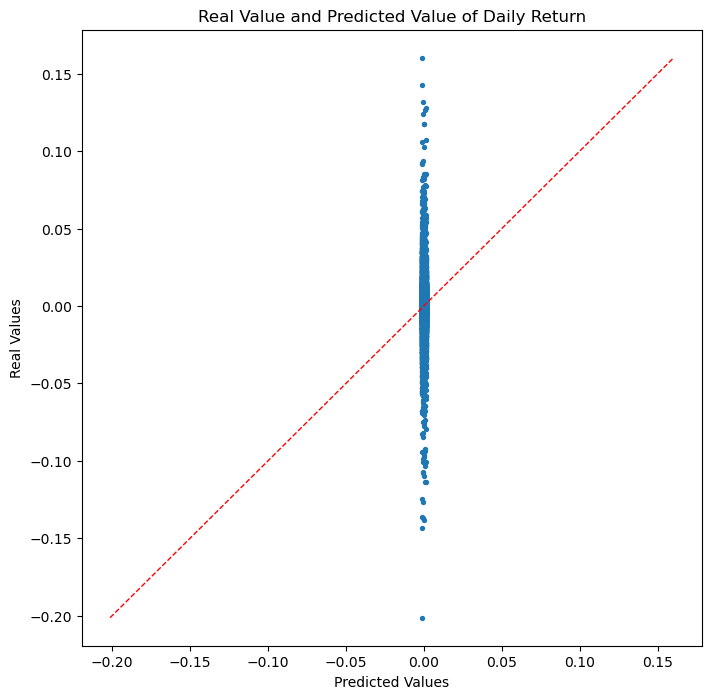

In [412]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
pred = df['pred'].values
real = df['real'].values
plt.scatter(pred, real, s=8)
# Add 45 degree line
x = np.linspace(min(pred.min(), real.min()), max(pred.max(), real.max()), 100)
plt.plot(x, x, color='red', linestyle='--', linewidth=1)
# Add labels and title
plt.xlabel('Predicted Values')
plt.ylabel('Real Values')
plt.title('Real Value and Predicted Value of Daily Return')

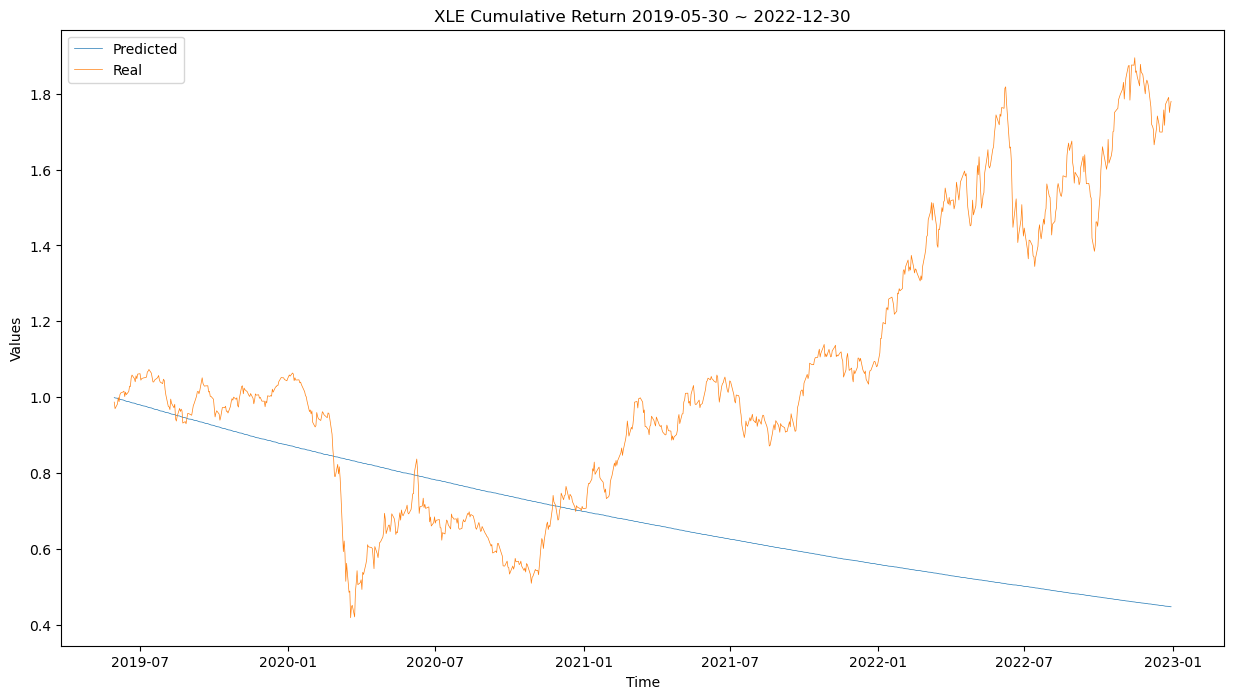

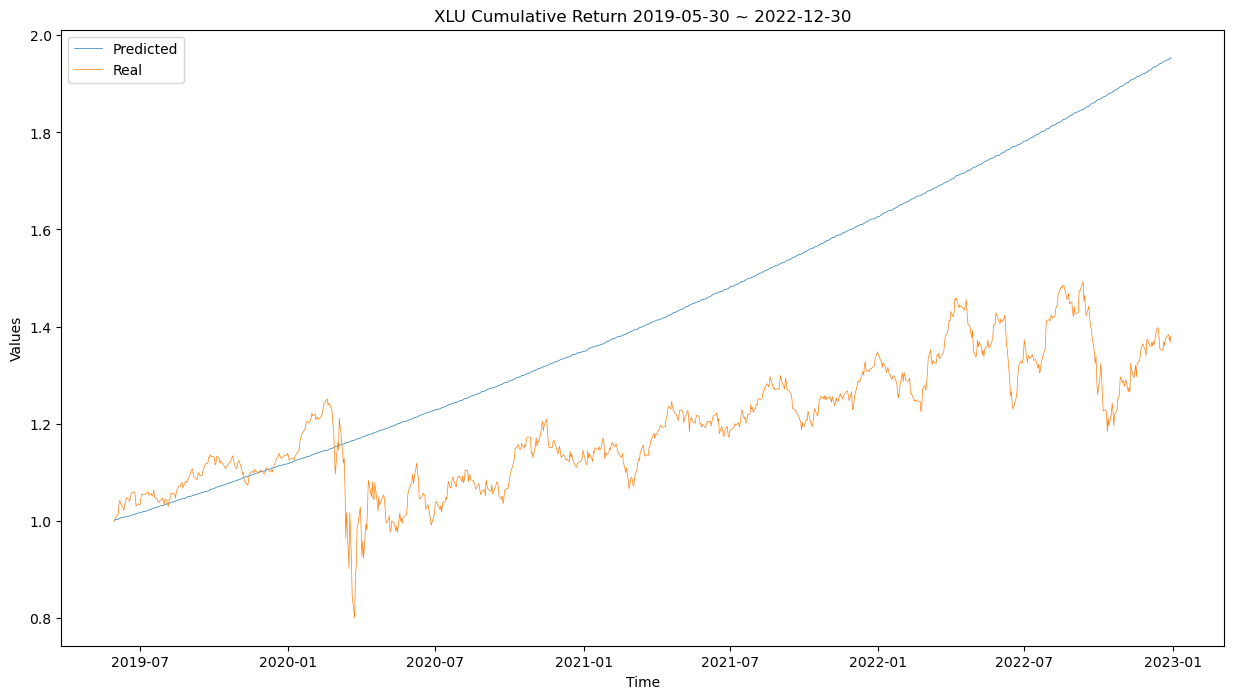

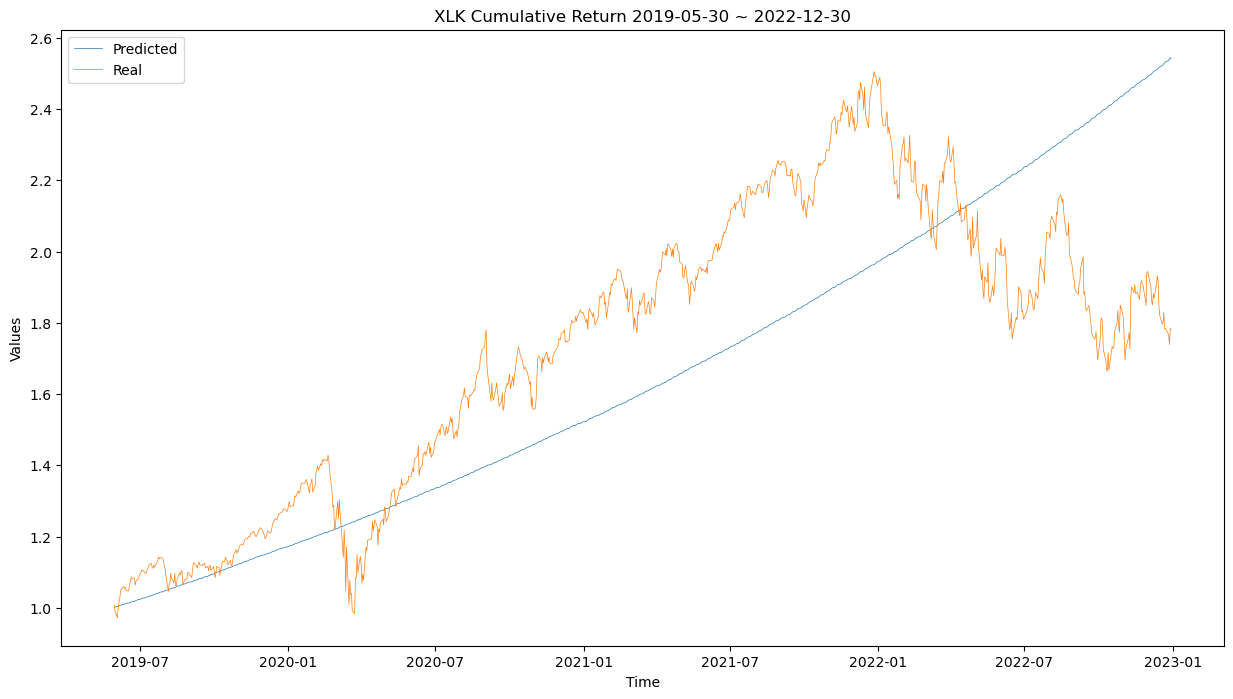

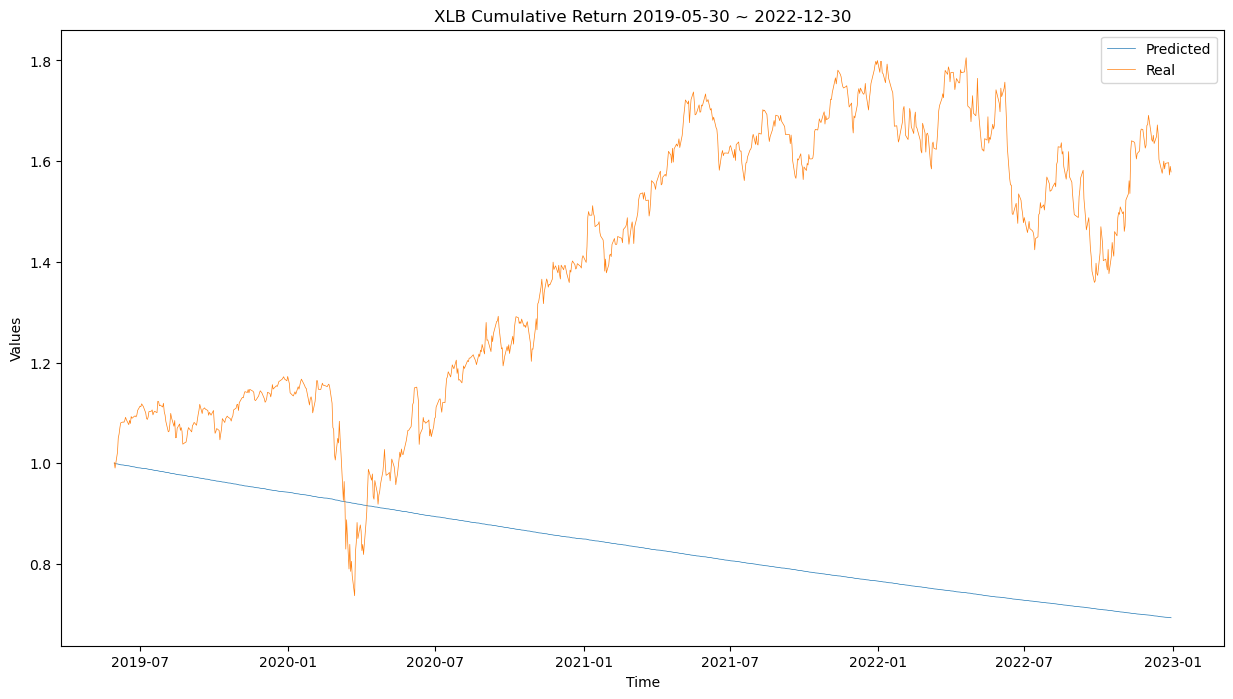

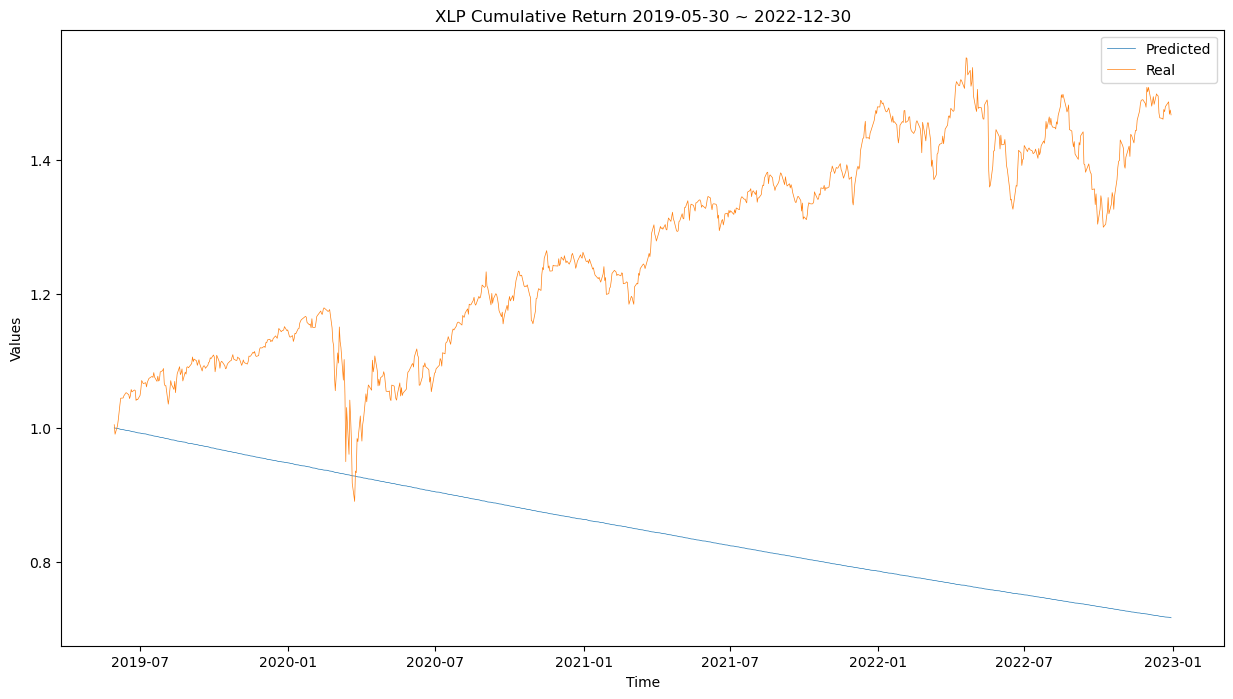

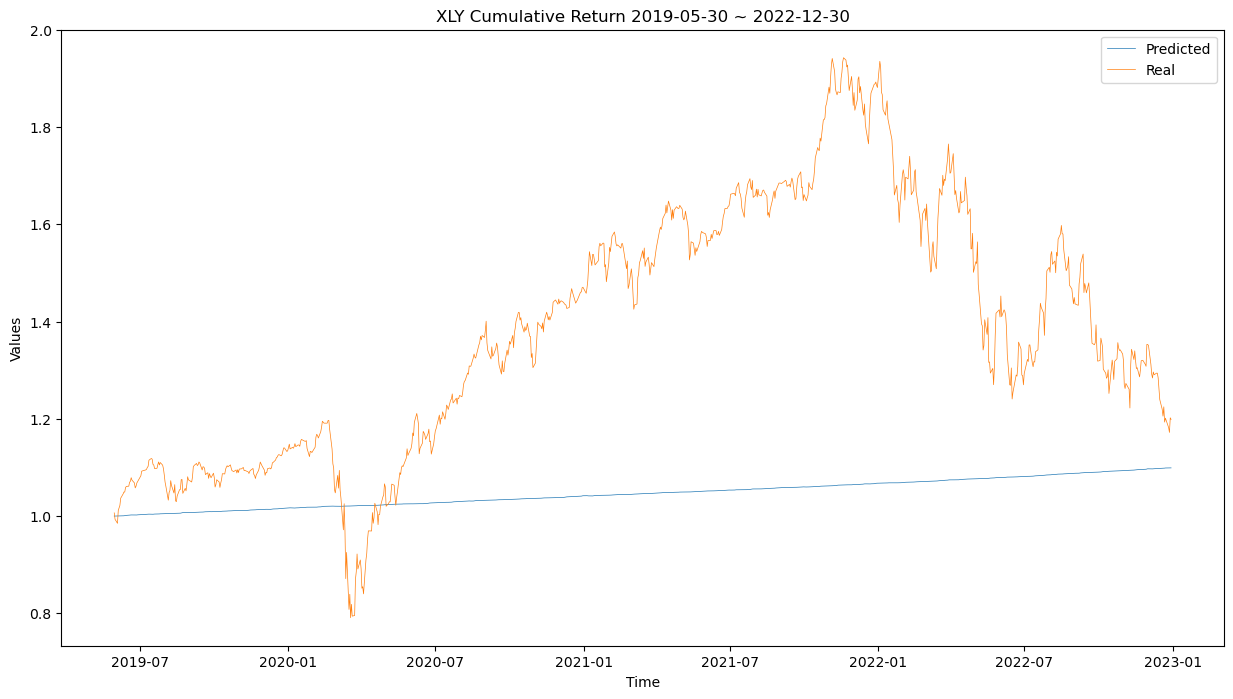

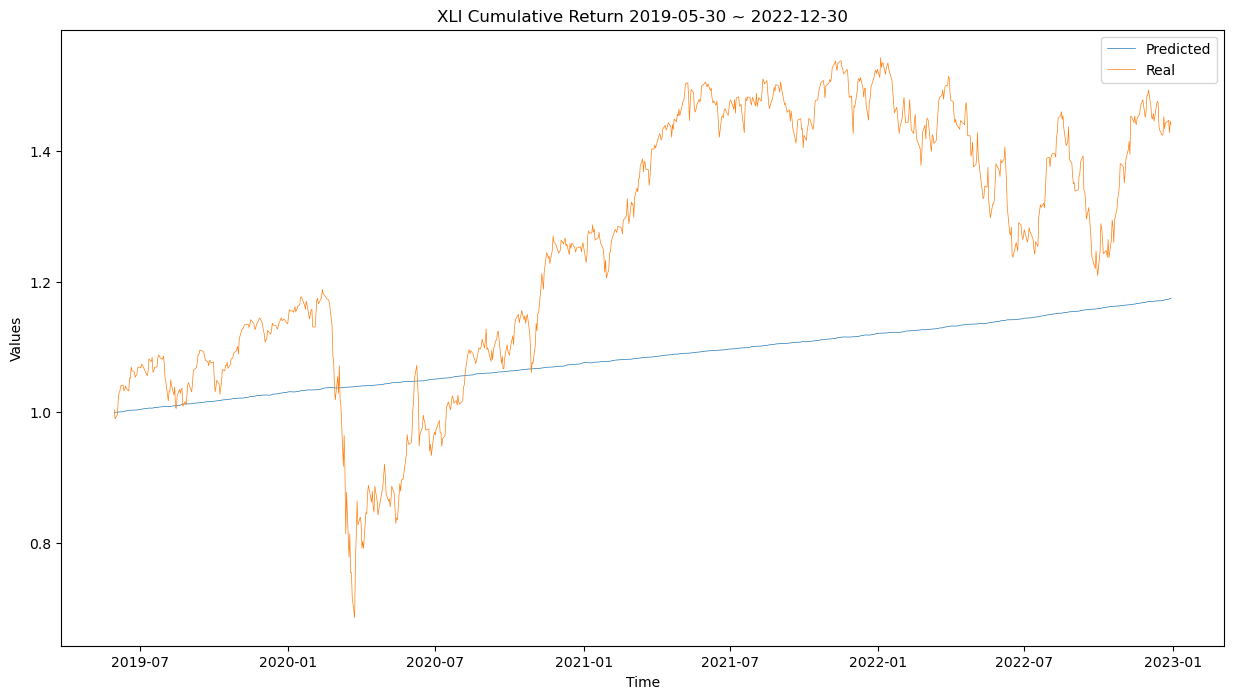

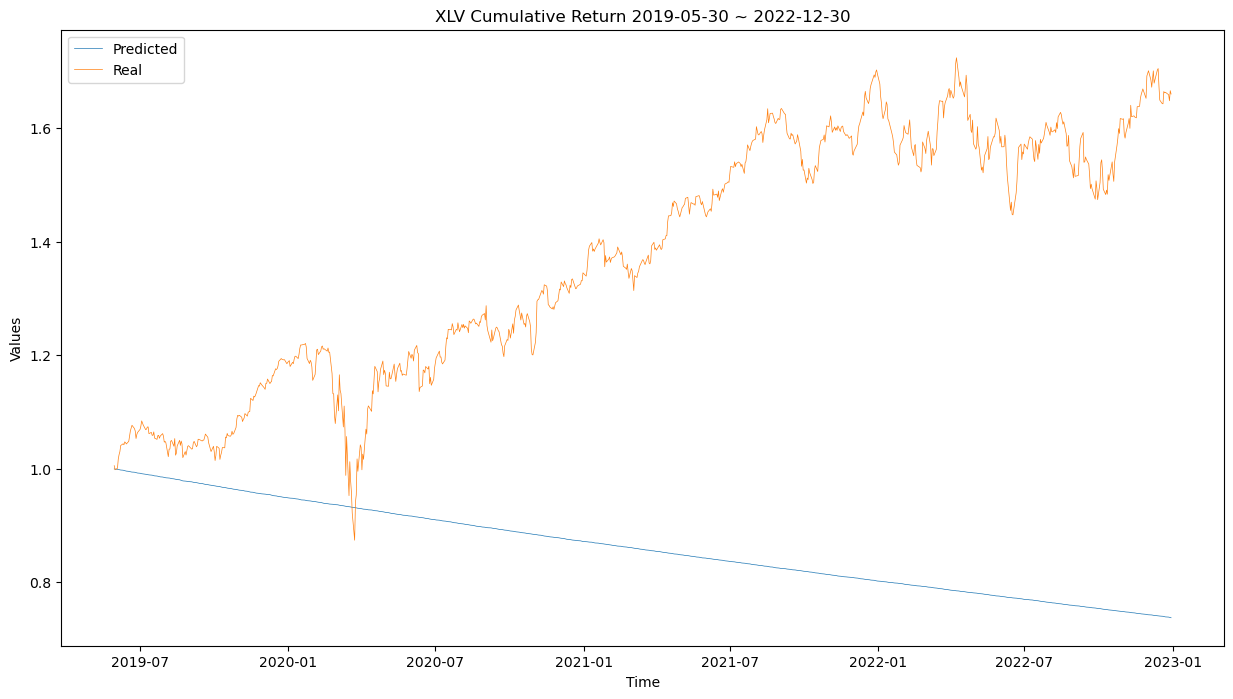

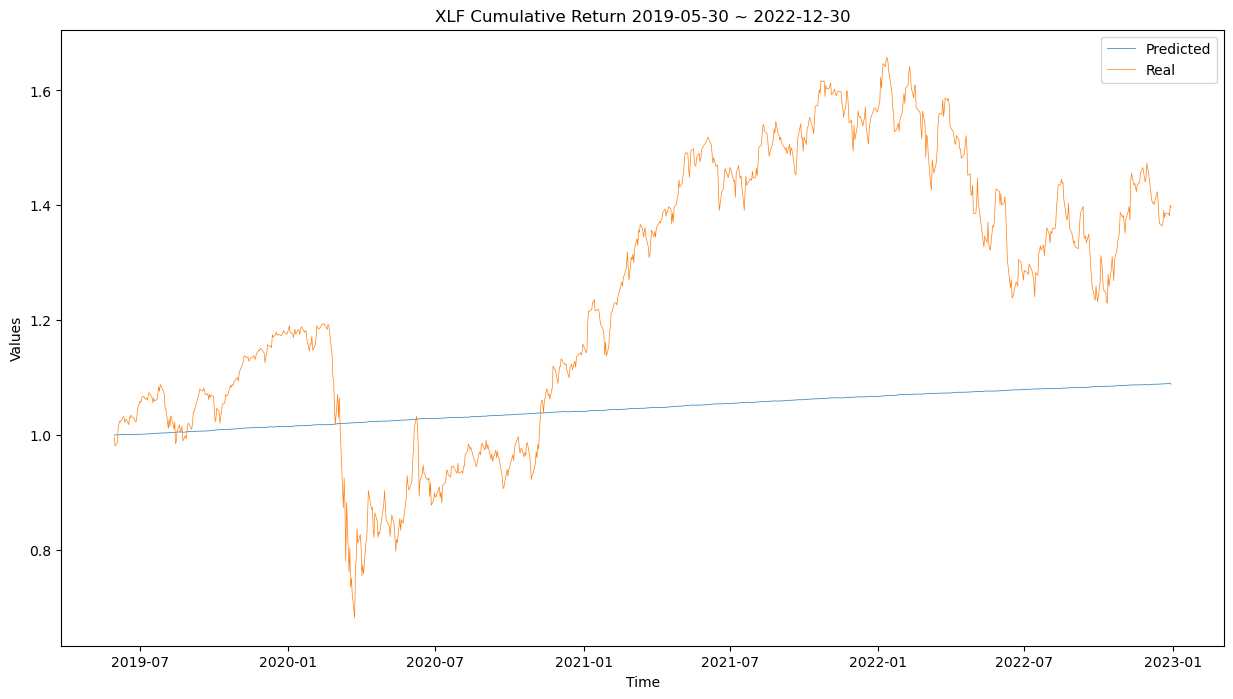

In [374]:
for i in range(9):
    sub_df = df[df['number']==i][['pred', 'real']]
    sub_df.index = data.loc[~data.index.duplicated(keep='first')][-len(y_test):].index
    
    plt.figure(figsize=(15, 8))
    plt.plot(sub_df.index, (1+ sub_df['pred']).cumprod(), label='Predicted', linewidth=0.5)
    plt.plot(sub_df.index, (1+ sub_df['real']).cumprod(), label='Real', linewidth=0.5)
    #plt.plot(sub_df.index, (sub_df['pred'] - sub_df['real']), label='Predicted Daily Return - Real Daily Return', linewidth=0.5)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title(f'{ticker_list[i]} Cumulative Return 2019-05-30 ~ 2022-12-30')
    plt.show()